# Miller et al., 2018 analysis walkthrough (Figs 3 and 7)

This uses code from the miller_ecog_tools github repository. Some of it I've copied into the notebook, but some of the analysis code makes the most sense in its original context (the brain plotting and the multivariate classification). We can view those files and go over in more detail. 

Basic steps, divided into two-ish stages  

**1a) Loading initial data from disk**
- Get subjects who performed a given experiment (`miller_ecog_tools.Utils.RAM_helpers.get_subjs_and_montages`)
- Load subject "events" (`miller_ecog_tools.Utils.RAM_helpers.load_subj_events`)
- Load subject electrode information (`miller_ecog_tools.Utils.RAM_helpers.load_elec_info`)
- Load subject EEG (`miller_ecog_tools.Utils.RAM_helpers.load_eeg`)

**1b) Compute spectral power from EEG**
- Compute spectral power for each event
 - `miller_ecog_tools.Utils.RAM_helpers.compute_power`, `miller_ecog_tools.Utils.RAM_helpers._parallel_compute_power`
 
**2) Run specified analyses on spectral power**
- **2a)** Subsequent memory univariate analyses (Figure 3)
 - `miller_ecog_tools.SubjectLevel.subject_analysis`, `miller_ecog_tools.SubjectLevel.Analyses.subject_SME`, `GroupLevel.Analyses.group_SME`
- **2b)** Multivariate classification of memory success (Figure 7)
 - `miller_ecog_tools.SubjectLevel.subject_analysis`, `miller_ecog_tools.SubjectLevel.Analyses.subject_classifier`, `miller_ecog_tools.SubjectLevel.Analyses.subject_classifier_using_n_features`

In [21]:
# import the basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline

from miller_ecog_tools.Utils import RAM_helpers
from miller_ecog_tools.subject import create_subject
from miller_ecog_tools.GroupLevel import group

# some extras 
import matplotlib as mpl
from scipy.stats import sem, ttest_1samp, ttest_rel

### 1a. Get a list of subjects who performed the Treasure Hunt 1 task

In [22]:
# excluding these to match the patients used in the published paper
exclude = ['R1132C', 'R1243T', 'R1244J','R1258T','R1230J','R1269E','R1259E','R1226D','R1214M' ,
           'R1215M', 'R1233E', 'R1263C','R1160C','R1282C','R1227T','R1182C','R1184M','R1198M']

In [23]:
subjs = RAM_helpers.get_subjs_and_montages(task='TH1')
mask = subjs['subject'].isin(exclude)
subjs = subjs[~mask]
subjs.head()

,subject,montage
0,R1076D,0
1,R1124J,0
3,R1133C,0
4,R1145J,0
5,R1147P,0


### 1a. Load events for an example subject

"Events" are what we call the behavioral data. Events are loaded from JSON files stored on our cluster, and returned as a DataFrame. Every row corresponds to a particular event that occured during the course of the experiment.


In [24]:
# use RAM_helpers to load events from disk for this subject
events = RAM_helpers.load_subj_events(task='TH1', subject=subjs.iloc[0].subject, montage=subjs.iloc[0].montage)

In [25]:
events.head()

,eegoffset,block,chestNum,chosenLocationX,chosenLocationY,confidence,distErr,eegfile,exp_version,experiment,...,reactionTime,recStartLocationX,recStartLocationY,recalled,session,stim_list,stim_params,subject,trial,type
0,285985,0,1,379.4456,348.6015,2,22.369162,R1076D_TH1_0_10Apr16_1754,,TH1,...,9567,384.5869,285,False,0,False,[],R1076D,0,CHEST
1,291566,0,2,-999.0000,-999.0000,-999,-999.000000,R1076D_TH1_0_10Apr16_1754,,TH1,...,-999,-999.0000,-999,False,0,False,[],R1076D,0,CHEST
2,296832,0,3,384.8549,364.3394,1,4.715555,R1076D_TH1_0_10Apr16_1754,,TH1,...,4183,384.5869,285,True,0,False,[],R1076D,0,CHEST
3,304315,0,4,384.6443,383.2017,2,6.084702,R1076D_TH1_0_10Apr16_1754,,TH1,...,5818,384.5869,285,True,0,False,[],R1076D,0,CHEST
4,315264,0,1,379.4456,348.6015,2,22.369162,R1076D_TH1_0_10Apr16_1754,,TH1,...,9567,384.5869,285,False,0,False,[],R1076D,0,REC


We are interested in item encoding events, so let's filter by event type to just the "CHEST" events. I can explain the basic behavioral paradigm in more detail as well.

Also, take note of the important columns like  
`eegoffset`: number of samples into the eegfile this event occurred  
`eegfile`: the name of the eegfile associated with this event  
`session`: The session number (0 indexed)  
`trial`: the trial number (0 indexed)  
`normDistErr`: the accuracy for measure for each trial

In [26]:
chest_events = events[(events.type=='CHEST') & (events.confidence >=0)]
chest_events.head()[['eegoffset', 'eegfile', 'trial', 'session', 'normErr', 'confidence']]

,eegoffset,eegfile,trial,session,normErr,confidence
0,285985,R1076D_TH1_0_10Apr16_1754,0,0,0.37443,2
2,296832,R1076D_TH1_0_10Apr16_1754,0,0,0.01682,1
3,304315,R1076D_TH1_0_10Apr16_1754,0,0,0.02820,2
7,369179,R1076D_TH1_0_10Apr16_1754,1,0,0.04321,2
8,374728,R1076D_TH1_0_10Apr16_1754,1,0,0.08759,2


### 1a. We also need to know about this subject's electrode configuration

So let's load a DataFrame with info about each electrode.

In [27]:
elec_info = RAM_helpers.load_elec_info(subject=subjs.iloc[0].subject, montage=subjs.iloc[0].montage)
elec_info.head()

,contact_1,contact_2,label,avg.dural.region,avg.dural.x,avg.dural.y,avg.dural.z,avg.region,avg.x,avg.y,...,ind.y,ind.z,is_explicit,is_stim_only,tal.region,tal.x,tal.y,tal.z,type_1,type_2
0,1,2,LFPG1-LFPG2,superiorfrontal,-17.646296,48.171718,35.812848,superiorfrontal,-15.205,42.785,...,34.535,46.855,False,False,None,-13.20865,45.95215,34.20855,G,G
1,1,9,LFPG1-LFPG9,rostralmiddlefrontal,-22.576937,50.263413,29.808138,rostralmiddlefrontal,-19.855,46.175,...,39.655,43.680,False,False,None,-17.83140,49.09395,29.82340,G,G
2,2,3,LFPG2-LFPG3,superiorfrontal,-19.649189,39.245760,43.491787,superiorfrontal,-15.880,34.455,...,24.790,49.735,False,False,None,-13.92125,38.17480,40.10235,G,G
3,2,10,LFPG2-LFPG10,rostralmiddlefrontal,-22.667159,43.289602,37.712965,superiorfrontal,-20.065,37.645,...,29.765,46.240,False,False,None,-18.09595,41.09915,35.43205,G,G
4,3,11,LFPG3-LFPG11,rostralmiddlefrontal,-26.045672,32.133296,44.744795,superiorfrontal,-20.790,29.750,...,20.330,49.555,False,False,None,-18.83790,33.76110,41.64005,G,G


### 1a. Load EEG, specifying the time relative to each event

The resulting data will be events x electrodes x time.

In [28]:
# Copied from From RAM_helpers.py

def load_eeg(events, rel_start_ms, rel_stop_ms, buf_ms=0, elec_scheme=None, noise_freq=[58., 62.],
             resample_freq=None, pass_band=None, use_mirror_buf=False, demean=False, do_average_ref=False):
    """
    Returns an EEG TimeSeries object.

    Parameters
    ----------
    events: pandas.DataFrame
        An events dataframe that contains eegoffset and eegfile fields
    rel_start_ms: int
        Initial time (in ms), relative to the onset of each event
    rel_stop_ms: int
        End time (in ms), relative to the onset of each event
    buf_ms:
        Amount of time (in ms) of buffer to add to both the begining and end of the time interval
    elec_scheme: pandas.DataFrame
        A dataframe of electrode information, returned by load_elec_info(). If the column 'contact' is in the dataframe,
        monopolar electrodes will be loads. If the columns 'contact_1' and 'contact_2' are in the df, bipolar will be
        loaded. You may pass in a subset of rows to only load data for electrodes in those rows.

        If you do not enter an elec_scheme, all monopolar channels will be loaded (but they will not be labeled with
        correct channel tags). Entering a scheme is recommended.
    noise_freq: list
        Stop filter will be applied to the given range. Default=(58. 62)
    resample_freq: float
        Sampling rate to resample to after loading eeg.
    pass_band: list
        If given, the eeg will be band pass filtered in the given range.
    use_mirror_buf: bool
        If True, the buffer will be data taken from within the rel_start_ms to rel_stop_ms interval,
        mirrored and prepended and appended to the timeseries. If False, data outside the rel_start_ms and rel_stop_ms
        interval will be read.
    demean: bool
        If True, will subject the mean voltage between rel_start_ms and rel_stop_ms from each channel
    do_average_ref: bool
        If True, will compute the average reference based on the mean voltage across channels

    Returns
    -------
    TimeSeries
        EEG timeseries object with dimensions channels x events x time (or bipolar_pairs x events x time)

        NOTE: The EEG data is returned with time buffer included. If you included a buffer and want to remove it,
              you may use the .remove_buffer() method. EXTRA NOTE: INPUT SECONDS FOR REMOVING BUFFER, NOT MS!!

    """

    # add buffer is using
    if (buf_ms is not None) and not use_mirror_buf:
        actual_start = rel_start_ms - buf_ms
        actual_stop = rel_stop_ms + buf_ms
    else:
        actual_start = rel_start_ms
        actual_stop = rel_stop_ms

    # load eeg
    eeg = CMLReader(subject=events.iloc[0].subject).load_eeg(events, rel_start=actual_start, rel_stop=actual_stop,
                                                             scheme=elec_scheme).to_ptsa()

    # now auto cast to float32 to help with memory issues with high sample rate data
    eeg.data = eeg.data.astype('float32')

    # compute average reference by subracting the mean across channels
    if do_average_ref:
        eeg = eeg - eeg.mean(dim='channel')

    # baseline correct subracting the mean within the baseline time range
    if demean:
        eeg = eeg.baseline_corrected([rel_start_ms, rel_stop_ms])

    # add mirror buffer if using. PTSA is expecting this to be in seconds.
    if use_mirror_buf:
        eeg = eeg.add_mirror_buffer(buf_ms / 1000.)

    # filter line noise
    if noise_freq is not None:
        if isinstance(noise_freq[0], float):
            noise_freq = [noise_freq]
        for this_noise_freq in noise_freq:
            for this_chan in range(eeg.shape[1]):
                b_filter = ButterworthFilter(eeg[:, this_chan:this_chan+1], this_noise_freq, filt_type='stop', order=4)
                eeg[:, this_chan:this_chan + 1] = b_filter.filter()

    # resample if desired. Note: can be a bit slow especially if have a lot of eeg data
    if resample_freq is not None:
        for this_chan in range(eeg.shape[1]):
            r_filter = ResampleFilter(eeg[:, this_chan:this_chan+1], resample_freq)
            eeg[:, this_chan:this_chan + 1] = r_filter.filter()

    # do band pass if desired.
    if pass_band is not None:
        eeg = band_pass_eeg(eeg, pass_band)

    # reorder dims to make events first
    eeg = make_events_first_dim(eeg)
    return eeg


In [29]:
eeg = RAM_helpers.load_eeg(chest_events, -500, 1500, elec_scheme=elec_info, demean=True)
print(eeg.shape)

(200, 60, 2000)


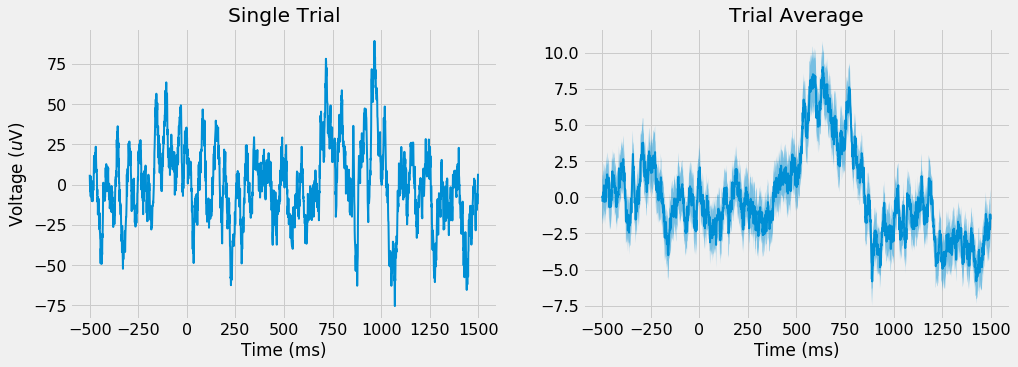

In [30]:
# Let's plot eeg data from the first channel as an example
elec_eeg = eeg[:, 0]
with plt.style.context('fivethirtyeight'):
    with mpl.rc_context({'ytick.labelsize': 16,
                         'xtick.labelsize': 16}):
        # left panel, single trial example
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.plot(elec_eeg.time, elec_eeg[0], lw=2)
        ax1.set_ylabel('Voltage ($u$V)')
        ax1.set_xlabel('Time (ms)')
        ax1.set_title('Single Trial')

        # right panel, average across events
        m = elec_eeg.mean(dim='event')
        err = sem(elec_eeg, axis=0)
        ax2.fill_between(elec_eeg.time, m-err, m+err, alpha=.5)
        ax2.plot(elec_eeg.time, m, lw=2)
        ax2.set_xlabel('Time (ms)')        
        ax2.set_title('Trial Average')

        fig.set_size_inches(15,5)

### 1b. Instead of looking at data in the time domain, we often look at at the spectral components of a signal

Here, we must define the frequencies at which we want to compute spectral power.

Since we are taking the mean across time, the dimensions will be events x frequencies x electrodes. For this demo, I'm only computing power for the first electrode

In [31]:
# define freqs
freqs = np.logspace(np.log10(1), np.log10(200), 30)

# compute power
elec_pow = RAM_helpers.compute_power(chest_events, freqs, 5,
                                 0, 1500,
                                 elec_scheme=elec_info.iloc[0:1], 
                                 mean_over_time=True)
print(elec_pow.shape)

(200, 30, 1)


In [32]:
# copied from RAM_helpers. It's does a lot, since I made it to mimic the functionality of the lab's old matlab code
def compute_power(events, freqs, wave_num, rel_start_ms, rel_stop_ms, buf_ms=1000, elec_scheme=None,
                  noise_freq=[58., 62.], resample_freq=None, mean_over_time=True, log_power=True, loop_over_chans=True,
                  cluster_pool=None, use_mirror_buf=False, time_bins=None, do_average_ref=False):
    """
    Returns a TimeSeries object of power values with dimensions 'events' x 'frequency' x 'bipolar_pairs/channels' x
    'time', unless mean_over_time is True, then no 'time' dimenstion.

    Parameters
    ----------
    events: pandas.DataFrame
        An events structure that contains eegoffset and eegfile fields
    freqs: np.array or list
        A set of frequencies at which to compute power using morlet wavelet transform
    wave_num: int
        Width of the wavelet in cycles (I THINK)
    rel_start_ms: int
        Initial time (in ms), relative to the onset of each event
    rel_stop_ms: int
        End time (in ms), relative to the onset of each event
    buf_ms:
        Amount of time (in ms) of buffer to add to both the begining and end of the time interval before power
        computation. This buffer is automatically removed before returning the power timeseries.
    elec_scheme: pandas.DataFrame:
        A dataframe of electrode information, returned by load_elec_info(). If the column 'contact' is in the dataframe,
        monopolar electrodes will be loads. If the columns 'contact_1' and 'contact_2' are in the df, bipolar will be
        loaded. You may pass in a subset of rows to only load data for electrodes in those rows.

        If you do not enter an elec_scheme, all monopolar channels will be loaded (but they will not be labeled with
        correct channel tags). Entering a scheme is recommended.
    noise_freq: list
        Stop filter will be applied to the given range. Default=(58. 62)
    resample_freq: float
        Sampling rate to resample to after loading eeg but BEFORE computing power. So be careful. Don't downsample below
        your nyquist.
    mean_over_time: bool
        Whether to mean power over time, and return the power data with no time dimension
    log_power: bool
        Whether to log the power values
    loop_over_chans: bool
        Whether to process each channel independently, or whether to try to do all channels at once. Default is to loop
    cluster_pool: None or ipython cluster helper pool
        If given, will parallelize over channels
    use_mirror_buf: bool
        If True, a mirror buffer will be (used see load_eeg) instead of a normal buffer
    time_bins: list or array
        pairs of start and stop times in which to bin the data
    do_average_ref: bool
        If true, will load eeg and then compute an average reference before computing power. Note: This will load eeg
        for all channels at once, regardless of loop_over_chans or cluster_pool. Will still loop for power computation.
    Returns
    -------
    timeseries object of power values

    """

    # warn people if they set the resample_freq too low
    if (resample_freq is not None) and (resample_freq < (np.max(freqs)*2.)):
        print('Resampling EEG below nyquist frequency.')
        warnings.warn('Resampling EEG below nyquist frequency.')

    # make freqs a numpy array if it isn't already because PTSA is kind of stupid and can't handle a list of numbers
    if isinstance(freqs, list):
        freqs = np.array(freqs)

    # if doing an average reference, load eeg first
    if do_average_ref:
        eeg_all_chans = load_eeg(events, rel_start_ms, rel_stop_ms, buf_ms=buf_ms, elec_scheme=elec_scheme,
                                 noise_freq=noise_freq, resample_freq=resample_freq, use_mirror_buf=use_mirror_buf,
                                 do_average_ref=do_average_ref)
    else:
        eeg_all_chans = None

    # We will loop over channels if desired or if we are are using a pool to parallelize
    if cluster_pool or loop_over_chans:

        # must enter an elec scheme if we want to loop over channels
        if elec_scheme is None:
            print('elec_scheme must be entered if loop_over_chans is True or using a cluster pool.')
            return

        # put all the inputs into one list. This is so because it is easier to parallize this way. Parallel functions
        # accept one input. The pool iterates over this list.
        arg_list = [(events, freqs, wave_num, elec_scheme.iloc[r:r + 1], rel_start_ms, rel_stop_ms,
                     buf_ms, noise_freq, resample_freq, mean_over_time, log_power, use_mirror_buf, time_bins,
                     eeg_all_chans[:, r:r + 1] if eeg_all_chans is not None else None)
                    for r in range(elec_scheme.shape[0])]

        # if no pool, just use regular map
        if cluster_pool is not None:
            pow_list = cluster_pool.map(_parallel_compute_power, arg_list)
        else:
            pow_list = list(map(_parallel_compute_power, tqdm(arg_list, disable=True if len(arg_list) == 1 else False)))

        # This is the stupidest thing in the world. I should just be able to do concat(pow_list, dim='channels') or
        # concat(pow_list, dim='bipolar_pairs'), but for some reason it breaks. I don't know. So I'm creating a new
        # TimeSeries object

        # concatenate data
        chan_dim = pow_list[0].get_axis_num('channel')
        elecs = np.concatenate([x[x.dims[chan_dim]].data for x in pow_list])
        pow_cat = np.concatenate([x.data for x in pow_list], axis=chan_dim)

        # create new coordinates and Timeseries with concatenated data and electrode info
        new_coords = {x: (pow_list[0].coords[x] if x != 'channel' else elecs) for x in pow_list[0].coords.keys()}
        wave_pow = TimeSeries(data=pow_cat, coords=new_coords, dims=pow_list[0].dims)

    # if not looping, sending all the channels at once
    else:
        arg_list = [events, freqs, wave_num, elec_scheme, rel_start_ms, rel_stop_ms, buf_ms, noise_freq,
                    resample_freq, mean_over_time, log_power, use_mirror_buf, time_bins, eeg_all_chans]
        wave_pow = _parallel_compute_power(arg_list)

    # reorder dims to make events first
    wave_pow = make_events_first_dim(wave_pow)

    return wave_pow


def _parallel_compute_power(arg_list):
    """
    Returns a timeseries object of power values. Accepts the inputs of compute_power() as a single list. Probably
    don't really need to call this directly.
    """

    events, freqs, wave_num, elec_scheme, rel_start_ms, rel_stop_ms, buf_ms, noise_freq, resample_freq, mean_over_time, \
    log_power, use_mirror_buf, time_bins, eeg = arg_list

    # first load eeg
    if eeg is None:
        eeg = load_eeg(events, rel_start_ms, rel_stop_ms, buf_ms=buf_ms, elec_scheme=elec_scheme,
                       noise_freq=noise_freq, resample_freq=resample_freq, use_mirror_buf=use_mirror_buf)

    # then compute power
    wave_pow = MorletWaveletFilter(eeg, freqs, output='power', width=wave_num, cpus=12,
                                   verbose=False).filter()

    # remove the buffer
    wave_pow = wave_pow.remove_buffer(buf_ms / 1000.)

    # are we taking the log?
    if log_power:
        data = wave_pow.data
        wave_pow.data = numexpr.evaluate('log10(data)')

    # mean over time if desired
    if mean_over_time:
        wave_pow = wave_pow.mean(dim='time')

    # or take the mean of each time bin, if given
    # create a new timeseries for each bin and the concat and add in new time dimension
    elif time_bins is not None:
        ts_list = []
        time_list = []
        for t in time_bins:
            t_inds = (wave_pow.time >= t[0]) & (wave_pow.time <= t[1])
            ts_list.append(wave_pow.isel(time=t_inds).mean(dim='time'))
            time_list.append(wave_pow.time.data[t_inds].mean())
        wave_pow = xr.concat(ts_list, dim='time')
        wave_pow.coords['time'] = time_list

    return wave_pow



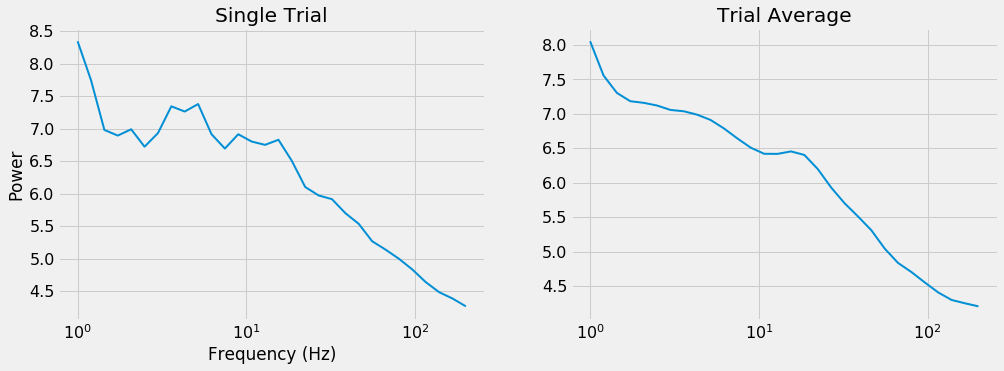

In [33]:
# Let's plot spectral power data from the first channel as an example
with plt.style.context('fivethirtyeight'):
    with mpl.rc_context({'ytick.labelsize': 16,
                         'xtick.labelsize': 16}):
        # left panel, single trial example
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.semilogx(elec_pow.frequency, elec_pow[0], lw=2)
        ax1.set_ylabel('Power')
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_title('Single Trial')

        # right panel, average across events
        m = elec_pow.mean(dim='event')
        ax2.semilogx(elec_pow.frequency, m, lw=2)
        ax1.set_xlabel('Frequency (Hz)')
        ax2.set_title('Trial Average')

        fig.set_size_inches(15,5)

## 2a) - Analysis: Subsequent Memory Effect

Here, using my `Group` class to automatically iterate over all subjects and run the specified analysis.

This analysis divides encoded items into "recalled" and "not recalled" items. It then peforms a two sample t-test at each electrode and frequency between these distributions. It then aggregates the results by brain region within subject, and computes group level statistics.

For a single subject (from class `SubjectLevel.Analyses.subject_SME.SubjectSMEAnalysis`):

In [34]:
# this is a snippet of a larger class. Some of this may be a bit opaque without me explaining 
# the overall structure of the miller_ecog_tools repo, but I can go into more detail.
def analysis(self):
    """
    Performs the subsequent memory analysis by comparing the distribution of remembered and not remembered items
    at each electrode and frequency using a two sample ttest.
    """
    if self.subject_data is None:
        print('%s: compute or load data first with .load_data()!' % self.subject)

    # Get recalled or not labels
    if self.recall_filter_func is None:
        print('%s SME: please provide a .recall_filter_func function.' % self.subject)
    recalled = self.recall_filter_func(self.subject_data)

    # zscore the data by session
    z_data = self.zscore_data()

    # for every frequency, electrode, timebin, subtract mean recalled from mean non-recalled zpower
    delta_z = np.nanmean(z_data[recalled], axis=0) - np.nanmean(z_data[~recalled], axis=0)
    delta_z = delta_z.reshape(self.subject_data.shape[1:])

    # run ttest at each frequency and electrode comparing remembered and not remembered events
    ts, ps, = ttest_ind(z_data[recalled], z_data[~recalled])

    # also do this by session
    sessions = self.subject_data.event.data['session']
    ts_by_sess = []
    ps_by_sess = []
    for sess in np.unique(sessions):
        sess_ind = sessions == sess
        ts_sess, ps_sess = ttest_ind(z_data[recalled & sess_ind], z_data[~recalled & sess_ind])
        ts_by_sess.append(ts_sess.reshape(len(self.freqs), -1))
        ps_by_sess.append(ps_sess.reshape(len(self.freqs), -1))

    # store results.
    self.res['zs'] = delta_z
    self.res['p_recall'] = np.mean(recalled)
    self.res['ts_sess'] = ts_by_sess
    self.res['ps_sess'] = ps_by_sess
    self.res['ts'] = ts
    self.res['ps'] = ps
    self.res['recalled'] = recalled

Run the above analysis on all subjects. Again, I'll need to explain a bit about how I've structured my code, but see `miller_ecog_tools.GroupLevel.group`.

In [36]:
# this function will define "good" and "bad" memory using a median split of distance errors
def rec_func(subject_data):
    return subject_data.event.data['normErr'] <= np.median(subject_data.event.data['normErr'])

# this will filter our evenrts to just encoding events
def event_func(events):
    return events[(events.type == 'CHEST') & (events.confidence >= 0)]

# some additional analysis parameters
params = {'freqs': np.logspace(np.log10(1), np.log10(200), 50),
                    'bipolar': True,
                    'mono_avg_ref': False,
                    'start_time': 0,
                    'end_time': 1500,
                    'recall_filter_func': rec_func,
                    'event_type': event_func,
                    'load_res_if_file_exists': True,
                    'do_not_compute': False
                   }

# create the group analysis object and run
group_data = group.Group(subject_montage=subjs, task='TH1', analysis_name='SubjectSMEAnalysis', **params)
group_data.run()

Processing R1076D - 0
R1076D: subject_data already exists, loading.
R1076D: loading results.
Processing R1124J - 0
R1124J: subject_data already exists, loading.
R1124J: loading results.
Processing R1133C - 0
R1133C: subject_data already exists, loading.
R1133C: loading results.
Processing R1145J - 0
R1145J: subject_data already exists, loading.
R1145J: loading results.
Processing R1147P - 0
R1147P: subject_data already exists, loading.
R1147P: loading results.
Processing R1154D - 0
R1154D: subject_data already exists, loading.
R1154D: loading results.
Processing R1155D - 0
R1155D: subject_data already exists, loading.
R1155D: loading results.
Processing R1155D - 2
R1155D: subject_data already exists, loading.
R1155D: loading results.
Processing R1156D - 0
R1156D: subject_data already exists, loading.
R1156D: loading results.
Processing R1157C - 0
R1157C: subject_data already exists, loading.
R1157C: loading results.
Processing R1163T - 0
R1163T: subject_data already exists, loading.
R1

And massage/aggregate all the subject data into a DF. From `GroupLevel.Analyses.group_SME.GroupSMEAnalysis`:

In [37]:
def create_res_df(self):
    """
    Create one dataframe with the t-statistics for every electrode, subject, frequency. Now you can do awewsome
    things like average by subject, region, frequency in one line like:

    df.groupby(['subject', 'regions', 'frequency']).mean().groupby(['regions', 'frequency']).mean()

    ------
    Returns dataframe with columns 'label', 'subject', 'regions', 'hemi', 'frequency', 't-stat', 'avg.x', 'avg.y',
    'avg.z'
    """

    # for each subject
    dfs = []
    for subj in self.analysis_objects:
        region_key = 'stein.region' if 'stein.region' in subj.elec_info else 'ind.region'
        hemi_key = 'ind.x'
        if subj.elec_info[hemi_key].iloc[0] == 'NaN':
            hemi_key = 'tal.x'
        regions = subj.bin_electrodes_by_region(elec_column1=region_key, x_coord_column=hemi_key)

        # get xyz from average brain
        xyz = subj.elec_info[['avg.x', 'avg.y', 'avg.z']]

        # make a dataframe
        df = pd.DataFrame(data=subj.res['ts'].T, columns=subj.freqs)
        df['label'] = regions['label']
        df['regions'] = regions['region']
        df['hemi'] = regions['hemi']
        df['subject'] = subj.subject
        df = pd.concat([df, xyz], axis=1)

        # melt it so that there is a row for every electrode and freqency
        df = df.melt(value_vars=subj.freqs, var_name='frequency', value_name='t-stat',
                     id_vars=['label', 'subject', 'regions', 'hemi', 'avg.x', 'avg.y', 'avg.z'])

        # append to list
        dfs.append(df)

    # make group df
    df = pd.concat(dfs)
    return df

We now have a DataFrame of all the t-statistics representing the direction and degree of the memory effect for each electrode and and frequency

In [38]:
print(group_data.group_helpers.group_df.shape)
group_data.group_helpers.group_df.head()

(227300, 9)


,label,subject,regions,hemi,avg.x,avg.y,avg.z,frequency,t-stat
0,LFPG1-LFPG2,R1076D,Frontal,left,-15.205,42.785,33.040,1,-1.506631
1,LFPG1-LFPG9,R1076D,Frontal,left,-19.855,46.175,28.445,1,0.697984
2,LFPG2-LFPG3,R1076D,Frontal,left,-15.880,34.455,39.020,1,0.001686
3,LFPG2-LFPG10,R1076D,Frontal,left,-20.065,37.645,34.160,1,-0.751615
4,LFPG3-LFPG11,R1076D,Frontal,left,-20.790,29.750,40.450,1,0.799062


### Miller et al., 2018 - Figure 3 Brain Map
Plot average activation on a brain model. See `GroupLevel.Analyses.group_SME.plot_group_brain_activation`

- Compute average activate (t-statistic) at each vertex
- Compute null distribution to identify sig. threshold. Parallelize permutations.

This will result in an interactive 3d rendered brain. I can run it when we go over the code.

In [40]:
ipy_fig = group_data.group_helpers.plot_group_brain_activation(radius=12.5, 
                                                               freq_range=[1, 10], 
                                                               clim=5, cmap='RdBu_r')

R1076D: finding valid vertices.
R1124J: finding valid vertices.
R1133C: finding valid vertices.
R1145J: finding valid vertices.
R1147P: finding valid vertices.
R1154D: finding valid vertices.
R1155D: finding valid vertices.
R1156D: finding valid vertices.
R1157C: finding valid vertices.
R1163T: finding valid vertices.
R1167M: finding valid vertices.
R1168T: finding valid vertices.
R1170J: finding valid vertices.
R1171M: finding valid vertices.
R1172E: finding valid vertices.
R1180C: finding valid vertices.
R1188C: finding valid vertices.
R1190P: finding valid vertices.
R1191J: finding valid vertices.
R1192C: finding valid vertices.
R1194E: finding valid vertices.
R1195E: finding valid vertices.
R1201P: finding valid vertices.
R1202M: finding valid vertices.
R1204T: finding valid vertices.
R1207J: finding valid vertices.
R1210E: finding valid vertices.
R1222M: finding valid vertices.
R1231M: finding valid vertices.
R1234D: finding valid vertices.
R1236J: finding valid vertices.
R1240T: 

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:   12.1s
[Parallel(n_jobs=12)]: Done  98 out of 100 | elapsed:   19.9s remaining:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   20.5s finished


### Miller et al., 2018 - Figure 3 Bar Plots
Plot average activation in the left and right hippocampus

In [41]:
# pretty simple manipulation of our DataFrame here. First filter to just the frequency range of interest and region
freq_range = [1,3]
within_range = group_data.group_helpers.group_df.frequency.between(*freq_range, inclusive=True)
within_range_df = group_data.group_helpers.group_df[within_range & (group_data.group_helpers.group_df.regions=='Hipp')]

# then mean by frequency within subject
within_subj_mean = within_range_df.groupby(['subject', 'regions', 'hemi']).mean().reset_index()
within_subj_mean.head()

,subject,regions,hemi,avg.x,avg.y,avg.z,t-stat
0,R1124J,Hipp,left,-32.657500,-19.625000,-23.26000,0.152884
1,R1133C,Hipp,right,27.718333,-26.244167,-13.65000,-0.497341
2,R1145J,Hipp,right,31.800000,-22.545000,-20.50500,-0.366304
3,R1147P,Hipp,left,-25.958750,-18.010000,-22.40125,-0.227554
4,R1154D,Hipp,left,-25.428000,-20.525000,-15.91100,1.091612


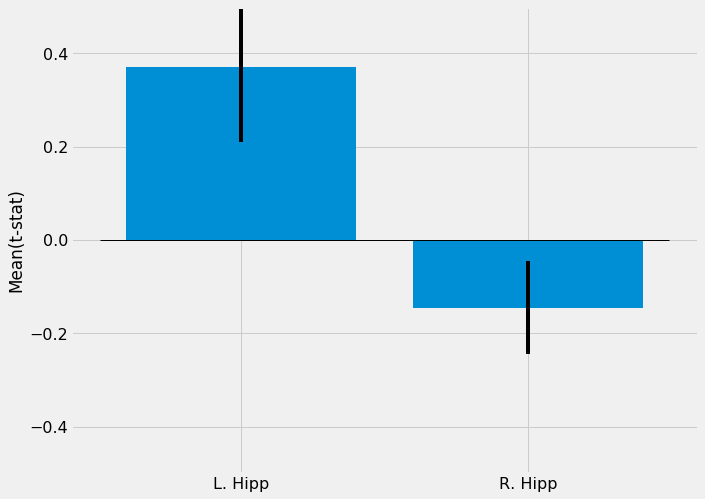

In [42]:
# now compute mean and standard error for each hemisphere
means = within_subj_mean.groupby(['hemi'])['t-stat'].mean()
errs = within_subj_mean.groupby(['hemi'])['t-stat'].sem()

# and plot it
with plt.style.context('fivethirtyeight'):
    with mpl.rc_context({'ytick.labelsize': 16,
                         'xtick.labelsize': 16}):
        plt.bar(range(2), means, yerr=errs)
        plt.xticks([0,1], ['L. Hipp', 'R. Hipp'])
        plt.ylabel('Mean(t-stat)')
        plt.plot(plt.xlim(), [0,0], '-k', lw=1)
        plt.ylim(-.5, .5)
        plt.gcf().set_size_inches(10,8)

## 2b) - Analysis: predicting single-trial memory success using multivariate classification

How well can spectral features predict single-trial behavior? This uses the exact same spectral data as discussed above, but here we are using a l2 regularized logistic regression to predict whether individual items will be successfully remembered.

See `SubjectLevel.Analyses.subject_classifier`, code not copied into notebook.

Classify based on  **low frequency** spectral features:

In [45]:
def rec_func(subject_data):
    return subject_data.event.data['normErr'] <= np.median(subject_data.event.data['normErr'])

# this will filter our evenrts to just encoding events
def event_func(events):
    return events[(events.type == 'CHEST') & (events.confidence >= 0)]

# some additional analysis parameters
params = {'freqs': np.logspace(np.log10(1), np.log10(10), 10),
                    'bipolar': True,
                    'mono_avg_ref': False,
                    'start_time': 0,
                    'end_time': 1500,
                    'recall_filter_func': rec_func,
                    'event_type': event_func,
                    'load_res_if_file_exists': True,
                    'do_not_compute': True,
                    'trial_field': 'trial'
                   }

# create the group analysis object and run
group_data_classifier_low_freqs = group.Group(subject_montage=subjs, task='TH1', 
                         analysis_name='SubjectClassifierAnalysis', **params)
group_data_classifier_low_freqs.run()

Processing R1076D - 0
R1076D: subject_data already exists, loading.
R1076D: loading results.
Processing R1124J - 0
R1124J: subject_data already exists, loading.
R1124J: loading results.
Processing R1133C - 0
R1133C: subject_data already exists, loading.
R1133C: loading results.
Processing R1145J - 0
R1145J: subject_data already exists, loading.
R1145J: loading results.
Processing R1147P - 0
R1147P: subject_data already exists, loading.
R1147P: loading results.
Processing R1154D - 0
R1154D: subject_data already exists, loading.
R1154D: loading results.
Processing R1155D - 0
R1155D: subject_data already exists, loading.
R1155D: No results to load.
ERROR PROCESSING R1155D.
Processing R1155D - 2
R1155D: subject_data already exists, loading.
R1155D: loading results.
Processing R1156D - 0
R1156D: subject_data already exists, loading.
R1156D: loading results.
Processing R1157C - 0
R1157C: subject_data already exists, loading.
R1157C: loading results.
Processing R1163T - 0
R1163T: subject_data

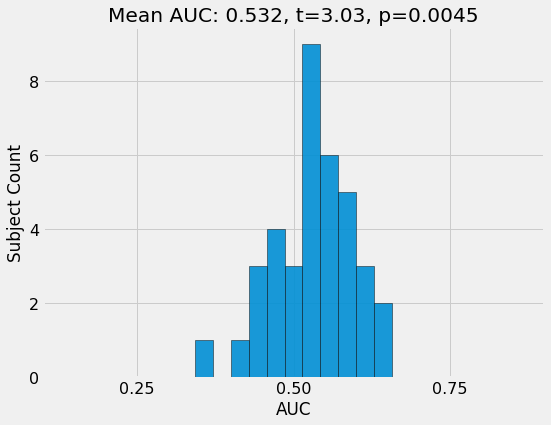

In [46]:
# plot distribution of AUC values
with plt.style.context('fivethirtyeight'):
    with mpl.rc_context({'ytick.labelsize': 16,
                         'xtick.labelsize': 16}):
        bins = np.linspace(0,1,36)
        group_data_classifier_low_freqs.group_helpers.subject_df.hist(column='auc', bins=bins, zorder=10, ec='k', alpha=.9)        
        m = group_data_classifier_low_freqs.group_helpers.subject_df['auc'].mean()
        t, p = ttest_1samp(group_data_classifier_low_freqs.group_helpers.subject_df['auc'], .5)
        plt.title(f'Mean AUC: {m:.3}, t={t:.3}, p={p:.3}')
        plt.ylabel('Subject Count')
        plt.xlabel('AUC')      
        plt.xlim(.1, .9)    
        plt.xticks([.25, .5, .75])
        plt.gcf().set_size_inches(8,6)

Classify based on  **high frequency** spectral features:

In [48]:
params = {'freqs': np.logspace(np.log10(40), np.log10(100), 10),
                    'bipolar': True,
                    'mono_avg_ref': False,
                    'start_time': 0,
                    'end_time': 1500,
                    'recall_filter_func': rec_func,
                    'event_type': event_func,
                    'load_res_if_file_exists': True,
                    'do_not_compute': True,
                    'trial_field': 'trial'
                   }

# create the group analysis object and run
group_data_classifier_high_freqs = group.Group(subject_montage=subjs, task='TH1', 
                         analysis_name='SubjectClassifierAnalysis', **params)
group_data_classifier_high_freqs.run()

Processing R1076D - 0
R1076D: subject_data already exists, loading.
R1076D: loading results.
Processing R1124J - 0
R1124J: subject_data already exists, loading.
R1124J: loading results.
Processing R1133C - 0
R1133C: subject_data already exists, loading.
R1133C: loading results.
Processing R1145J - 0
R1145J: subject_data already exists, loading.
R1145J: loading results.
Processing R1147P - 0
R1147P: subject_data already exists, loading.
R1147P: loading results.
Processing R1154D - 0
R1154D: subject_data already exists, loading.
R1154D: loading results.
Processing R1155D - 0
R1155D: subject_data already exists, loading.
R1155D: No results to load.
ERROR PROCESSING R1155D.
Processing R1155D - 2
R1155D: subject_data already exists, loading.
R1155D: loading results.
Processing R1156D - 0
R1156D: subject_data already exists, loading.
R1156D: loading results.
Processing R1157C - 0
R1157C: subject_data already exists, loading.
R1157C: loading results.
Processing R1163T - 0
R1163T: subject_data

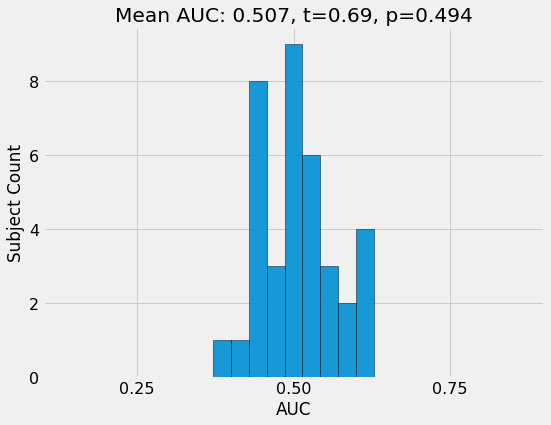

In [49]:
# plot distribution of AUC values
with plt.style.context('fivethirtyeight'):
    with mpl.rc_context({'ytick.labelsize': 16,
                         'xtick.labelsize': 16}):
        bins = np.linspace(0,1,36)
        group_data_classifier_high_freqs.group_helpers.subject_df.hist(column='auc', bins=bins, zorder=10, ec='k', alpha=.9)        
        m = group_data_classifier_high_freqs.group_helpers.subject_df['auc'].mean()
        t, p = ttest_1samp(group_data_classifier_high_freqs.group_helpers.subject_df['auc'], .5)
        plt.title(f'Mean AUC: {m:.3}, t={t:.3}, p={p:.3}')
        plt.ylabel('Subject Count')
        plt.xlabel('AUC')      
        plt.xlim(.1, .9)    
        plt.xticks([.25, .5, .75])        
        plt.gcf().set_size_inches(8,6)

Low frequency features tend to perform better. In other words, more memory-related information is present in the lower frequencies. Left panel is the same analysis as Figure 7a in the paper.

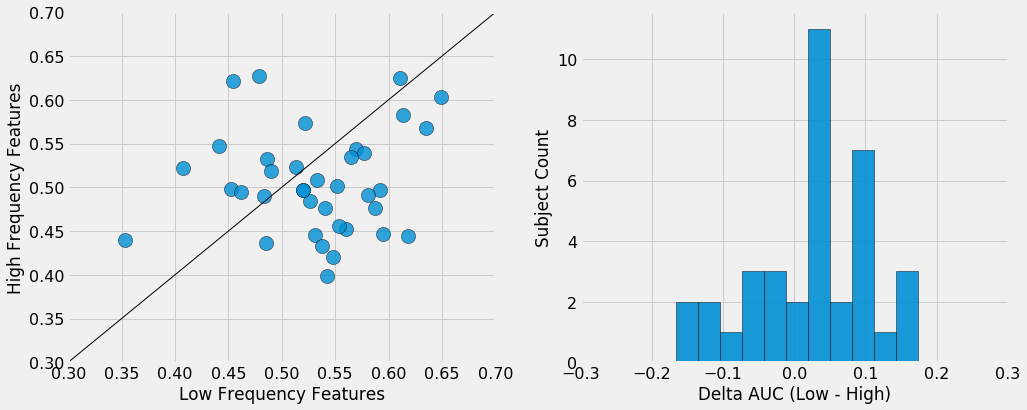

In [50]:
y = group_data_classifier_high_freqs.group_helpers.subject_df['auc']
x = group_data_classifier_low_freqs.group_helpers.subject_df['auc']
with plt.style.context('fivethirtyeight'):
    with mpl.rc_context({'ytick.labelsize': 16,
                         'xtick.labelsize': 16}):
        
        fig, (ax1, ax2) = plt.subplots(1,2)

        # left panel - scatter plot of low vs high frequency features.
        ax1.scatter(x,y,s=200, alpha=.8, edgecolor='k')
        ax1.plot([.3,.9], [.3,.9],'-k', lw=1)
        ax1.set_xlim(.3, .7)
        ax1.set_ylim(.3, .7)        
        ax1.set_ylabel('High Frequency Features')
        ax1.set_xlabel('Low Frequency Features')    
        
        # right panel - histograms of the differences
        ax2.hist(x-y, bins=11, ec='k', alpha=.9)
        ax2.set_xlim(-.3, .3)
        ax2.set_ylabel('Subject Count')
        ax2.set_xlabel('Delta AUC (Low - High)')
        plt.gcf().set_size_inches(15,6)

## 2b) - Analysis: is the "memory signal" distributed across the brain?

The prior analysis shows that we can decode memory success or failure based on the brain activity present during encoding, but the analysis doesn't tell us anything about the distributed nature of the neural signals. In other words, is the same *information* present on each electrode (are the electrodes/signals redundant), or is the information from different electrodes not completely overlapping.

See `SubjectLevel.Analyses.subject_classifier`, and now `SubjectLevel.Analyses.subject_classifier_using_n_features`. Code not copied into notebook.

Classify based on  **low frequency** spectral features, iterating over number of electrodes included

In [51]:
# low freq
params_low_freq = {'freqs': np.logspace(np.log10(1), np.log10(10), 10),
                    'bipolar': True,
                    'mono_avg_ref': False,
                    'start_time': 0,
                    'end_time': 1500,
                    'recall_filter_func': rec_func,
                    'event_type': event_func,
                    'load_res_if_file_exists': True,
                    'do_not_compute': True,
                    'num_rand_splits': 1000,
                    'use_joblib': True
                   }

# create the group analysis object and run
group_data_n_features_low_freq = group.Group(subject_montage=subjs, task='TH1', 
                                             analysis_name='SubjectClassifierNFeaturesAnalysis', 
                                             **params_low_freq)
group_data_n_features_low_freq.run()

Processing R1076D - 0
R1076D: subject_data already exists, loading.
R1076D: loading results.
Processing R1124J - 0
R1124J: subject_data already exists, loading.
R1124J: loading results.
Processing R1133C - 0
R1133C: subject_data already exists, loading.
R1133C: loading results.
Processing R1145J - 0
R1145J: subject_data already exists, loading.
R1145J: loading results.
Processing R1147P - 0
R1147P: subject_data already exists, loading.
R1147P: loading results.
Processing R1154D - 0
R1154D: subject_data already exists, loading.
R1154D: loading results.
Processing R1155D - 0
R1155D: subject_data already exists, loading.
R1155D: No results to load.


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


ERROR PROCESSING R1155D.
Processing R1155D - 2
R1155D: subject_data already exists, loading.
R1155D: loading results.
Processing R1156D - 0
R1156D: subject_data already exists, loading.
R1156D: loading results.
Processing R1157C - 0
R1157C: subject_data already exists, loading.
R1157C: loading results.
Processing R1163T - 0
R1163T: subject_data already exists, loading.
R1163T: loading results.
Processing R1167M - 0
R1167M: subject_data already exists, loading.
R1167M: loading results.
Processing R1168T - 0
R1168T: subject_data already exists, loading.
R1168T: loading results.
Processing R1170J - 0
R1170J: subject_data already exists, loading.
R1170J: loading results.
Processing R1170J - 2
R1170J: subject_data already exists, loading.
R1170J: loading results.
Processing R1171M - 0
R1171M: subject_data already exists, loading.
R1171M: loading results.
Processing R1172E - 0
R1172E: subject_data already exists, loading.
R1172E: loading results.
Processing R1180C - 0
R1180C: subject_data al

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


ERROR PROCESSING R1285C.
Processing R1289C - 0
R1289C: subject_data already exists, loading.
R1289C: No results to load.


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


ERROR PROCESSING R1289C.


Classify based on  **high frequency** spectral features, iterating over number of electrodes included

In [52]:
# high freq
params_high_freq = {'freqs': np.logspace(np.log10(40), np.log10(100), 10),
                    'bipolar': True,
                    'mono_avg_ref': False,
                    'start_time': 0,
                    'end_time': 1500,
                    'recall_filter_func': rec_func,
                    'event_type': event_func,
                    'load_res_if_file_exists': True,
                    'do_not_compute': True,
                    'num_rand_splits': 1000,
                    'use_joblib': True
                   }

# create the group analysis object and run
group_data_n_features_high_freq = group.Group(subject_montage=subjs, task='TH1', 
                                              analysis_name='SubjectClassifierNFeaturesAnalysis', 
                                              **params_high_freq)
group_data_n_features_high_freq.run()

Processing R1076D - 0
R1076D: subject_data already exists, loading.
R1076D: loading results.
Processing R1124J - 0
R1124J: subject_data already exists, loading.
R1124J: loading results.
Processing R1133C - 0
R1133C: subject_data already exists, loading.
R1133C: loading results.
Processing R1145J - 0
R1145J: subject_data already exists, loading.
R1145J: loading results.
Processing R1147P - 0
R1147P: subject_data already exists, loading.
R1147P: loading results.
Processing R1154D - 0
R1154D: subject_data already exists, loading.
R1154D: loading results.
Processing R1155D - 0
R1155D: subject_data already exists, loading.
R1155D: No results to load.


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  55 tasks      | elapsed:    3.0s


ERROR PROCESSING R1155D.
Processing R1155D - 2
R1155D: subject_data already exists, loading.
R1155D: loading results.
Processing R1156D - 0
R1156D: subject_data already exists, loading.
R1156D: loading results.
Processing R1157C - 0
R1157C: subject_data already exists, loading.
R1157C: loading results.
Processing R1163T - 0
R1163T: subject_data already exists, loading.
R1163T: loading results.
Processing R1167M - 0
R1167M: subject_data already exists, loading.
R1167M: loading results.
Processing R1168T - 0
R1168T: subject_data already exists, loading.
R1168T: loading results.
Processing R1170J - 0
R1170J: subject_data already exists, loading.
R1170J: loading results.
Processing R1170J - 2
R1170J: subject_data already exists, loading.
R1170J: loading results.
Processing R1171M - 0
R1171M: subject_data already exists, loading.
R1171M: loading results.
Processing R1172E - 0
R1172E: subject_data already exists, loading.
R1172E: loading results.
Processing R1180C - 0
R1180C: subject_data al

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


ERROR PROCESSING R1285C.
Processing R1289C - 0
R1289C: subject_data already exists, loading.
R1289C: No results to load.


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


ERROR PROCESSING R1289C.


Grab the AUC values for the first 50 electrodes for each subject. Plot (left) AUC as a function of number of electrodes for low (blue line) and high (red line) frequency features. Plot (right) the diffence in AUC between low and high. This is the same analysis as the Figure 7b in the paper.

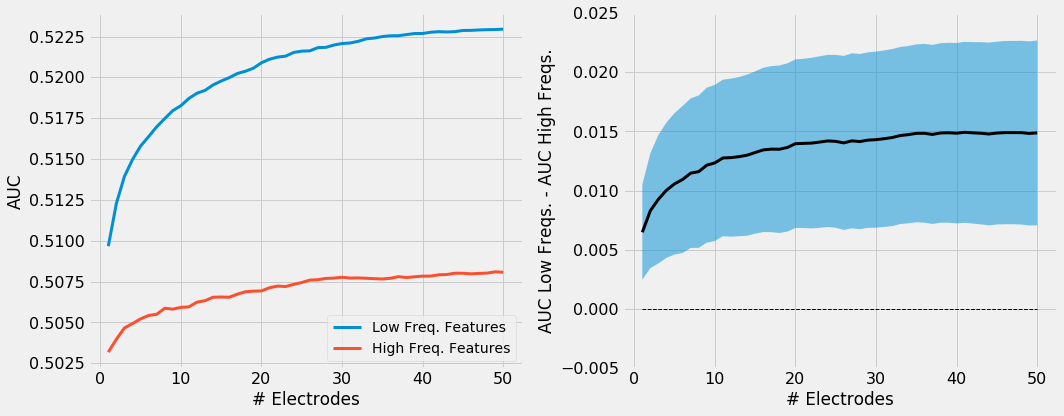

In [53]:
# aggregate data from the first 50 electrodes in each subject
aucs_high = np.stack([x.res['auc_x_n'].mean(axis=0)[:50] for x in group_data_n_features_high_freq.subject_objs])
aucs_low = np.stack([x.res['auc_x_n'].mean(axis=0)[:50] for x in group_data_n_features_low_freq.subject_objs])
aucs_diff = aucs_low - aucs_high

with plt.style.context('fivethirtyeight'):
    with mpl.rc_context({'ytick.labelsize': 16,
                         'xtick.labelsize': 16}):
        
        fig, (ax1, ax2) = plt.subplots(1,2)
                
        # left panel - mean auc as a function of number of electrodes for low and high freq. features
        m_high = aucs_high.mean(axis=0)
        m_low = aucs_low.mean(axis=0)        
        x = np.arange(1, len(m_high) + 1)
        ax1.plot(x, m_low, lw=3, label='Low Freq. Features')          
        ax1.plot(x, m_high, lw=3, label='High Freq. Features')    
        ax1.set_ylabel('AUC')
        ax1.set_xlabel('# Electrodes')          
        ax1.legend()
        
        # right panel - the difference between low and high as a function of number of electrodes.
        e = sem(aucs_diff)
        m = aucs_diff.mean(axis=0)
        x = np.arange(1, len(m) + 1)
        ax2.fill_between(x, m - e, m + e, alpha=.5)            
        ax2.plot(x, m, '-k', lw=3)
        ax2.plot(x, np.zeros(np.shape(x)), '--k', lw=1)        
        ax2.set_ylabel('AUC Low Freqs. - AUC High Freqs.')
        ax2.set_xlabel('# Electrodes')
        ax2.set_ylim(-.005,.025)
        
        plt.gcf().set_size_inches(15, 6)
        plt.tight_layout()

In [20]:
import warnings
warnings.filterwarnings("ignore")